In [1]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [3]:
mp_holistic = mp.solutions.holistic #Holistic Model
mp_drawing = mp.solutions.drawing_utils #Drawing Utilities

In [4]:
def mediapipe_detection(image, model) :
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 #Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)   # COLOR CONVERSION from RGB to BGR
    return image, results

In [5]:
def draw_landmarks(image, results) :
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)  # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [6]:
def draw_styled_landmarks(image, results) :
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
                             )
    # Draw hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                             )

In [7]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic :
    while cap.isOpened() :
        # Read feed
        ret, frame = cap.read()
    
        # Make Detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        #Draw Landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q') :
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
len(results.right_hand_landmarks.landmark)

21

In [9]:
draw_landmarks(frame, results)

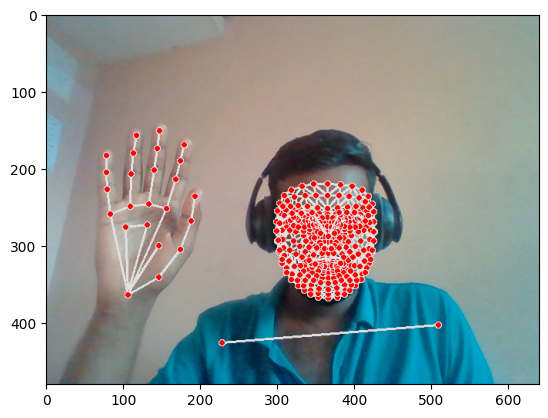

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [107]:
results.pose_landmarks.landmark[0]

x: 0.4859635829925537
y: 0.36560124158859253
z: -0.7633506059646606
visibility: 0.9998502731323242

In [12]:
def extract_keypoints(results) :
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [13]:
test_results = extract_keypoints(results) 
len(test_results)

1662

In [26]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')
# Actions that we try to detect 
actions = np.array(['Hello', 'Bye', 'Thanks', 'I-Love-You', 'Please', 'Help', 'Alarm', 'Afraid', 'Yes', 'No' ])
# Fifty videos worth of data
no_sequences = 30
# Videos are going to be 50 frames in length
sequence_length = 30

In [23]:
for action in actions :
    for sequence in range(no_sequences) :
        try :
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except :
            pass

In [24]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic :
    # Loop through actions
    for action in actions :
        # Loop through sequence aka videos
        for sequence in range(no_sequences) :
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length) :
                # Read feed
                ret, frame = cap.read()
            
                # Make Detections
                image, results = mediapipe_detection(frame, holistic)
                # print(results)
        
                #Draw Landmarks
                draw_styled_landmarks(image, results)

                # Apply wait logic
                if frame_num == 0 :
                    cv2.putText(image, 'STARTING COLLECTION', (120, 120),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0 ,0 ,255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else :
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q') :
                    break
                     
    cap.release()
    cv2.destroyAllWindows()

In [17]:
cap.release()
cv2.destroyAllWindows()

In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # used for one hot encoding

In [27]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Hello': 0,
 'Bye': 1,
 'Thanks': 2,
 'I-Love-You': 3,
 'Please': 4,
 'Help': 5,
 'Alarm': 6,
 'Afraid': 7,
 'Yes': 8,
 'No': 9}

In [28]:
sequences, labels = [], []
for action in actions :
    for sequence in range(no_sequences) :
        window = []
        for frame_num in range(sequence_length) :
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [29]:
np.array(sequences).shape

(300, 30, 1662)

In [30]:
np.array(labels).shape

(300,)

In [31]:
X = np.array(sequences)

In [32]:
Y = to_categorical(labels).astype(int)
Y.shape

(300, 10)

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

In [35]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [45]:
model = Sequential([
    LSTM(64, return_sequences = True, activation ='relu', input_shape=(30, 1662)),
    Dropout(0.3),
    LSTM(128, return_sequences = True, activation ='relu'),
    Dropout(0.3),
    LSTM(64, return_sequences = False, activation ='relu'),
    Dropout(0.3),
    Dense(64, activation ='relu'),
    Dense(32, activation ='relu'),
    Dense(actions.shape[0], activation='softmax')
])

In [46]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [138]:
class myCallback(tf.keras.callbacks.Callback) :
    def on_epoch_end(self, epoch, logs={}) :
        accuracy = logs.get('categorical_accuracy')
        if(accuracy is not None and accuracy >= 0.98) :
            print("\n Reached 995% accuracy... So cancelling training!!!")
            self.model.stop_training = True
mycallback = myCallback()

In [139]:
model.fit(X_train, Y_train, epochs=250, callbacks=[mycallback])

Epoch 1/250
9/9 [==============================] - 1s 107ms/step - loss: 0.1762 - categorical_accuracy: 0.9368
Epoch 2/250
9/9 [==============================] - 1s 105ms/step - loss: 0.1024 - categorical_accuracy: 0.9719
Epoch 3/250
9/9 [==============================] - 1s 101ms/step - loss: 0.0930 - categorical_accuracy: 0.9754
Epoch 4/250
9/9 [==============================] - ETA: 0s - loss: 0.0542 - categorical_accuracy: 0.9895
 Reached 995% accuracy... So cancelling training!!!
9/9 [==============================] - 1s 105ms/step - loss: 0.0542 - categorical_accuracy: 0.9895


In [110]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 64)            442112    
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [140]:
res = model.predict(X_test)

1/1 [==============================] - 0s 63ms/step


In [145]:
actions[np.argmax(res[8])]

'Bye'

In [146]:
actions[np.argmax(Y_test[8])]

'Bye'

In [166]:
model.save('model_1-98p.h5')

e:\high-scale-projects\final_year_project\mediapipe-lstm_slr-model\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [90]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [147]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 78ms/step


In [148]:
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [149]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[12,  0],
        [ 1,  2]],

       [[12,  1],
        [ 0,  2]],

       [[13,  1],
        [ 0,  1]],

       [[14,  0],
        [ 0,  1]],

       [[14,  1],
        [ 0,  0]],

       [[13,  0],
        [ 1,  1]],

       [[13,  0],
        [ 1,  1]],

       [[14,  0],
        [ 0,  1]],

       [[12,  0],
        [ 0,  3]]], dtype=int64)

In [155]:
accuracy_score(ytrue, yhat)

0.8

In [98]:
# colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
# def prob_viz(res, actions, input_frame, colors) :
#     output_frame = input_frame.copy()
#     for num, prob in enumerate(res) :
#         cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
#         cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
#     return output_frame

In [99]:
# plt.imshow(prob_viz(res, actions, image, colors))

In [170]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        # draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.insert(0, keypoints)
        sequence = sequence[:30]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            # image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [165]:
cap.release()
cv2.destroyAllWindows()